# フィボナッチ・リトレースメントのデモ

In [1]:
import pandas as pd
import mplfinance as mpf
from datetime import date, datetime, timedelta
import yfinance as yf
import pandas_ta as ta

In [2]:
# 最高値、最安値からフィボナッチ・リトレースメント水準を計算する
def fibonacci_retracement_levels(high, low):
    difference = high - low
    return {
        '0% (magenta)': high,
        '23.6% (cyan)': high - difference * 0.236,
        '38.2% (blue)': high - difference * 0.382,
        '50% (red)': high - difference * 0.5,
        '61.8% (green)': high - difference * 0.618,
        '76.4% (orange)': high - difference * 0.764,
        '100% (purple)': low
    }

# 外れ値を除外する
def exclude_outliers_statistical(data, n_std):
    mean_price = data['Close'].mean()
    std_dev = data['Close'].std()
    return data[(data['Close'] >= mean_price - n_std * std_dev) & (data['Close'] <= mean_price + n_std * std_dev)]
def exclude_outliers_percentage(data, threshold=10):
    median_price = data['Close'].median()
    return data[(data['Close'] >= median_price * (1 - threshold / 100)) & (data['Close'] <= median_price * (1 + threshold / 100))]

# 最近の高値と安値を求める
def recent_highs_lows(data, lookback_period):
    recent_data = data[-lookback_period:]
    recent_high = recent_data['Close'].max()
    recent_low = recent_data['Close'].min()
    return recent_high, recent_low


[*********************100%%**********************]  1 of 1 completed


 
{'0% (magenta)': 11920.0, '23.6% (cyan)': 10617.28, '38.2% (blue)': 9811.36, '50% (red)': 9160.0, '61.8% (green)': 8508.64, '76.4% (orange)': 7702.72, '100% (purple)': 6400.0}


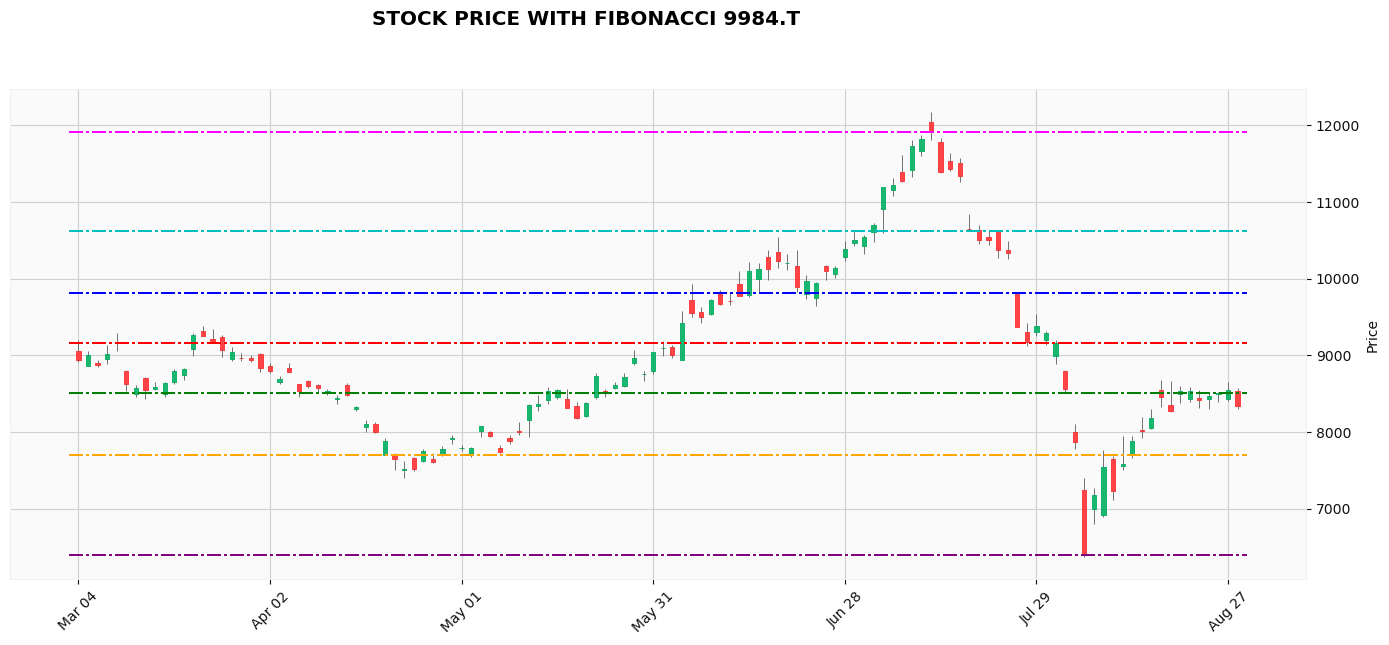

In [3]:
# 実行本体コード
def main(stock_symbol='9984.T', outlier_method='statistical', n_std=3.0, threshold=10, base_lookback=180, recent_lookback=60):
    end_date = date.today()
    start_date = end_date - timedelta(days=base_lookback)
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    if outlier_method == 'statistical':
        data_no_outliers = exclude_outliers_statistical(data, n_std)
    elif outlier_method == 'percentage':
        data_no_outliers = exclude_outliers_percentage(data, threshold)
    recent_high, recent_low = recent_highs_lows(data_no_outliers, recent_lookback)
    fib_levels_recent = fibonacci_retracement_levels(recent_high, recent_low)
    print(' '); print(fib_levels_recent)
    mpf.plot(data,type='candle',style='yahoo',figsize =(18,7),
          hlines=dict(hlines=list(fib_levels_recent.values()), colors=['magenta','c','b','r','g','orange','purple'],linestyle='-.'),
          title = "STOCK PRICE WITH FIBONACCI {0}".format(stock_symbol))
if __name__ == "__main__":
    main()